In [35]:
import sys
import scipy.io as sio
import h5py
import numpy as np
from os.path import join as oj
import matplotlib.pyplot as plt
# %matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
import pandas as pd
import torch
sys.path.insert(1, oj(sys.path[0], '..'))  # insert parent path

from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn import decomposition
import matplotlib.gridspec as grd
from sklearn import neural_network
from torch.nn import functional as F
from torch import nn, optim


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
from stringer_dset import StringerDset
dset = StringerDset()

In [17]:
gan_dir = '/accounts/projects/vision/chandan/gan/cifar100_dcgan_grayscale'
sys.path.insert(1, gan_dir)

In [22]:
num_gpu = 1 if torch.cuda.is_available() else 0
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# load the models
from dcgan import Discriminator, Generator

D = Discriminator(ngpu=num_gpu)
G = Generator(ngpu=num_gpu)

# load weights
D.load_state_dict(torch.load(oj(gan_dir, 'samples/netD_epoch_9.pth')))
G.load_state_dict(torch.load(oj(gan_dir, 'samples/netG_epoch_9.pth')))
if torch.cuda.is_available():
    D = D.cuda()
    G = G.cuda()

# generate random ims

torch.Size([25, 100, 1, 1])


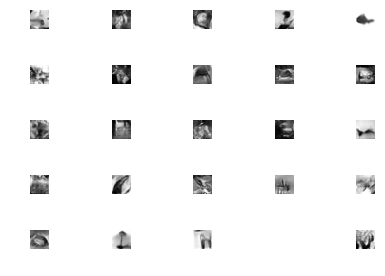

In [44]:

batch_size = 25
latent_size = 100

fixed_noise = torch.randn(batch_size, latent_size, 1, 1).to(device)
print(fixed_noise.shape)
fake_images = G(fixed_noise)

fake_images_np = fake_images.cpu().detach().numpy()
fake_images_np = fake_images_np.reshape(fake_images_np.shape[0], 32, 32)
# fake_images_np = fake_images_np.transpose((0, 2, 3, 1))
R, C = 5, 5
for i in range(batch_size):
    plt.subplot(R, C, i + 1)
    plt.imshow(fake_images_np[i], interpolation='bilinear', cmap='gray')
    plt.axis('off')
    plt.tight_layout()
plt.show()

# fit latent space

In [45]:
class Net(nn.Module):
    def __init__(self, G):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(11449, 100) # num_neurons to latent space
        self.G = G

    def forward(self, x):
        x = self.fc1(x)
        print(x.shape)
        im = self.G(x)
        return im

(im, resp) = dset[:2000]

model = Net(G).to(device)
ims = torch.Tensor(im).to(device)
resps = torch.Tensor(resp).to(device)

class p:
    its = 10
    
for it in range(p.its):
    ims_pred = model(ims)

'''
for it in its:
    data = data.to(device=device, non_blocking=True)
    target = target.to(device=device, non_blocking=True)
    output = model(data)
    test_loss += F.nll_loss(output, target, reduction='sum').item()
    pred = output.argmax(1, keepdim=True)
    correct += pred.eq(target.view_as(pred)).sum().item()
'''

RuntimeError: size mismatch, m1: [136000 x 90], m2: [11449 x 100] at /pytorch/aten/src/THC/generic/THCTensorMathBlas.cu:266